# Decision Tree Classifier Demo — Breast Cancer Dataset (From Scratch)

This notebook demonstrates a Decision Tree classifier implemented entirely from scratch using the `rice2025` package.

We will:

- Load and preprocess the Breast Cancer dataset  
- Encode categorical features  
- Fit our custom Decision Tree  
- Evaluate model accuracy  
- Visualize 2D decision regions using our custom PCA implementation  


## Understanding Decision Trees — Intuition and Math

A **Decision Tree** is a supervised learning model that makes predictions by repeatedly splitting the data into smaller, more “pure” subsets.  
Each split is based on a simple rule such as:

- *Is Tumor Size ≤ 20 mm?*
- *Is Estrogen Status = Positive?*
- *Is T Stage = T2?*

This creates a flowchart-like structure where each internal node is a decision, and each leaf node predicts a class (Alive or Dead).

---

### 🧠 Intuition

Decision Trees try to partition the dataset into regions where the target variable is as homogeneous as possible.  

Example intuition:

- If tumor size is large, risk of mortality increases.  
- If lymph nodes are positive, risk increases further.  
- If differentiation is well-differentiated, risk decreases.  

The model learns these kinds of thresholds automatically.

---

### 📉 Entropy (Impurity Measure)

To decide how “pure” a node is, we compute **entropy**:

$$
H(y) = - \sum_{c} p(c)\log_2 p(c)
$$

Where:
- \( p(c) \) is the proportion of samples belonging to class \( c \)  
- Low entropy → mostly one class (good split)  
- High entropy → mixed classes (bad split)

---

### 🔍 Information Gain (How We Choose Splits)

At each node, the tree evaluates all features and all possible thresholds and picks the best split based on **information gain**:

$$
IG = H(\text{parent}) - \left( p_L H(L) + p_R H(R) \right)
$$

Where:
- \( H(\text{parent}) \) is the entropy before the split  
- \( H(L), H(R) \) are entropies of left and right children  
- \( p_L, p_R \) are proportions of samples sent to each child  

**The tree chooses the split with the highest information gain.**

---

### 🌳 How the Tree Grows

1. Start with the full dataset.  
2. Evaluate every possible split (feature + threshold).  
3. Pick the one with highest information gain.  
4. Partition the data into left/right subsets.  
5. Repeat recursively until:
   - All samples are pure, or  
   - Max depth is reached  

---

### ⚖️ Depth, Overfitting, and Regularization

- A *deep* tree can memorize the training set → high variance  
- A *shallow* tree generalizes better → lower variance  
- `max_depth` controls this tradeoff  

Your implementation allows `max_depth` to prevent overfitting.

---

### ⭐ Strengths of Decision Trees
- Easy to interpret  
- Handles mixed feature types  
- No feature scaling needed  
- Captures nonlinear relationships  

### ⚠️ Weaknesses
- Deep trees overfit  
- Small data changes can affect structure  
- Hard to visualize in high dimensions  

---

In this notebook, we apply our custom Decision Tree implementation to the Wine Quality dataset, train it, evaluate accuracy, and visualize decision boundaries using PCA.


## Wine Quality Dataset

The **Wine Quality Red** dataset contains 1,599 Portuguese red wines, each described by 11 physicochemical properties:

- fixed acidity  
- volatile acidity  
- citric acid  
- residual sugar  
- chlorides  
- free sulfur dioxide  
- total sulfur dioxide  
- density  
- pH  
- sulphates  
- alcohol  

The original target variable is **quality**, an integer from 0–10.  
We will convert this into a binary target:

- **1 = good wine** (quality ≥ 6)  
- **0 = bad wine** (quality < 6)  

This allows us to use a Decision Tree classifier.


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("winequality-red.csv")
df.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


## Exploratory Data Analysis

Before modeling, we examine:

- Data shape  
- Distribution of the quality scores  
- Basic statistics of the physicochemical predictors  


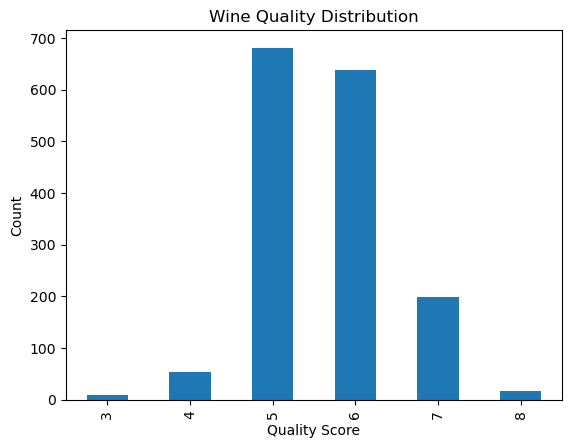

In [6]:
df["quality"].value_counts().sort_index().plot(kind="bar")
plt.title("Wine Quality Distribution")
plt.xlabel("Quality Score")
plt.ylabel("Count")
plt.show()


## How Chemical Properties Relate to Wine Quality

We explore how each feature behaves for **good** vs **bad** wines.  
This helps us anticipate which splits a Decision Tree might choose.

Examples:

- Higher **alcohol** → better wines  
- Higher **volatile acidity** → worse wines  
- Higher **sulphates** → better wines  
- Higher **density** → often worse wines  


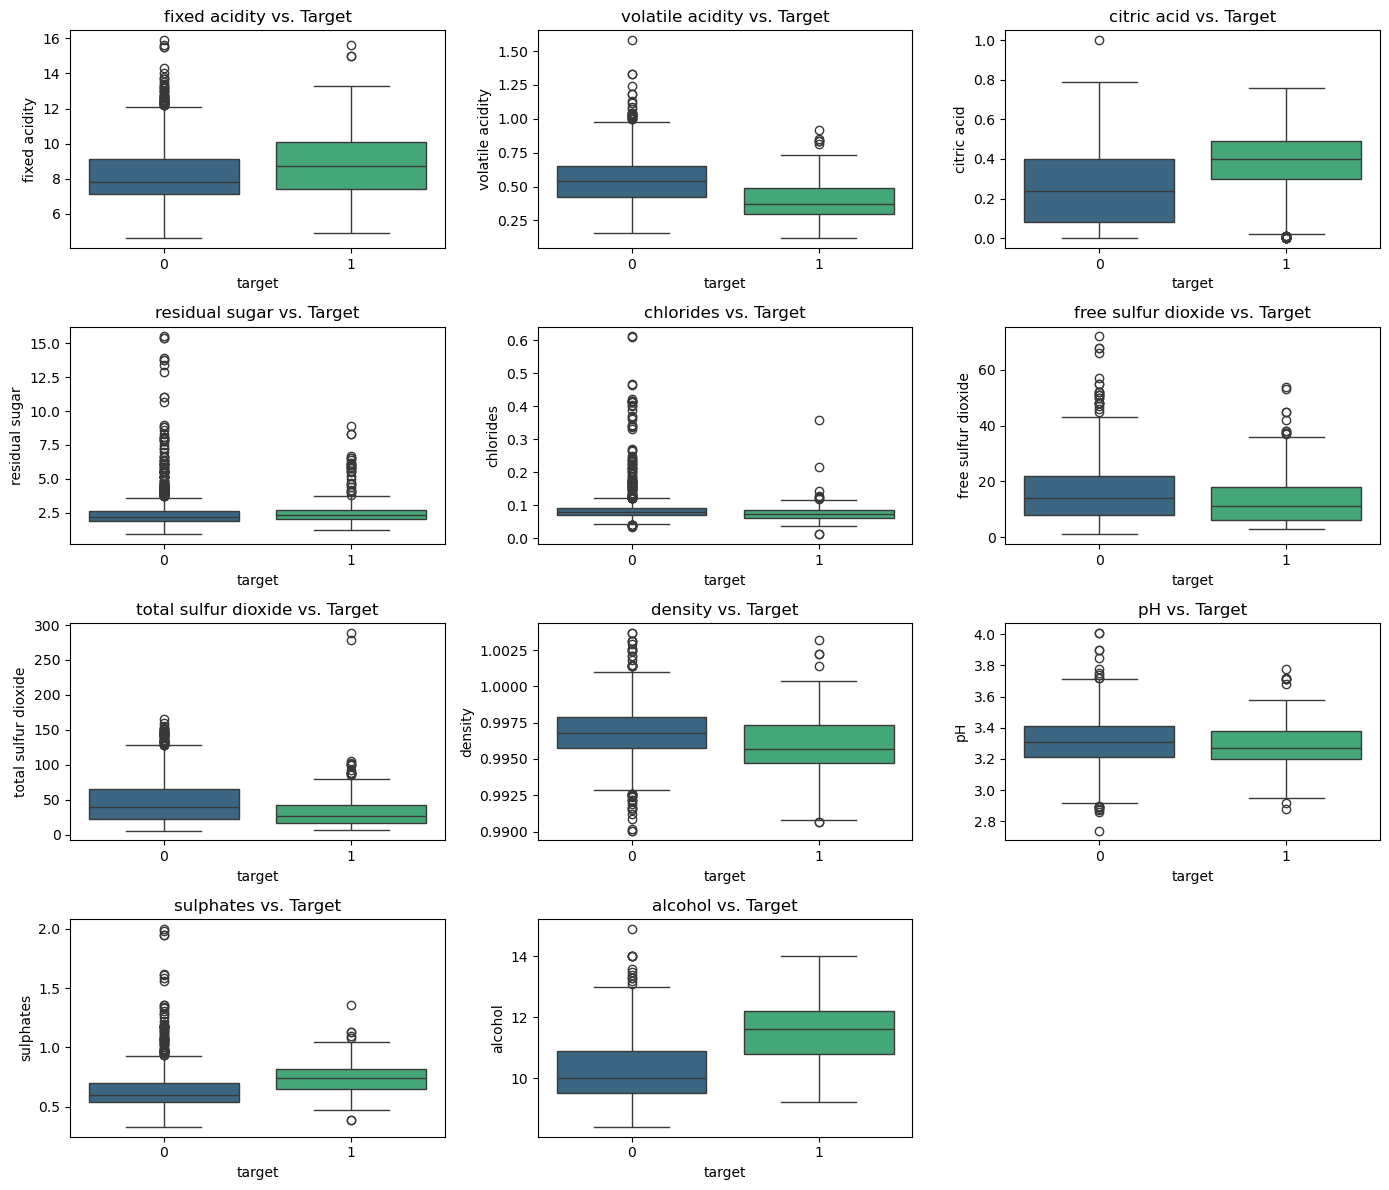

In [8]:
# Make sure target exists
df["target"] = (df["quality"] >= 7).astype(int)

plt.figure(figsize=(14, 12))

for i, col in enumerate(df.drop(columns=["quality", "target"]).columns, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(
        data=df,
        x="target",
        y=col,
        hue="target",
        dodge=False,
        palette="viridis",
        legend=False
    )
    plt.title(f"{col} vs. Target")

plt.tight_layout()
plt.show()



## Correlation Structure

Decision Trees do not require linear relationships,  
but understanding feature correlations helps us see redundancy.

For example:

- Free sulfur dioxide & total sulfur dioxide are highly correlated  
- Density is strongly tied to residual sugar  
- Alcohol, sulphates, and volatile acidity are strong predictors of quality  

We visualize the correlation matrix next.


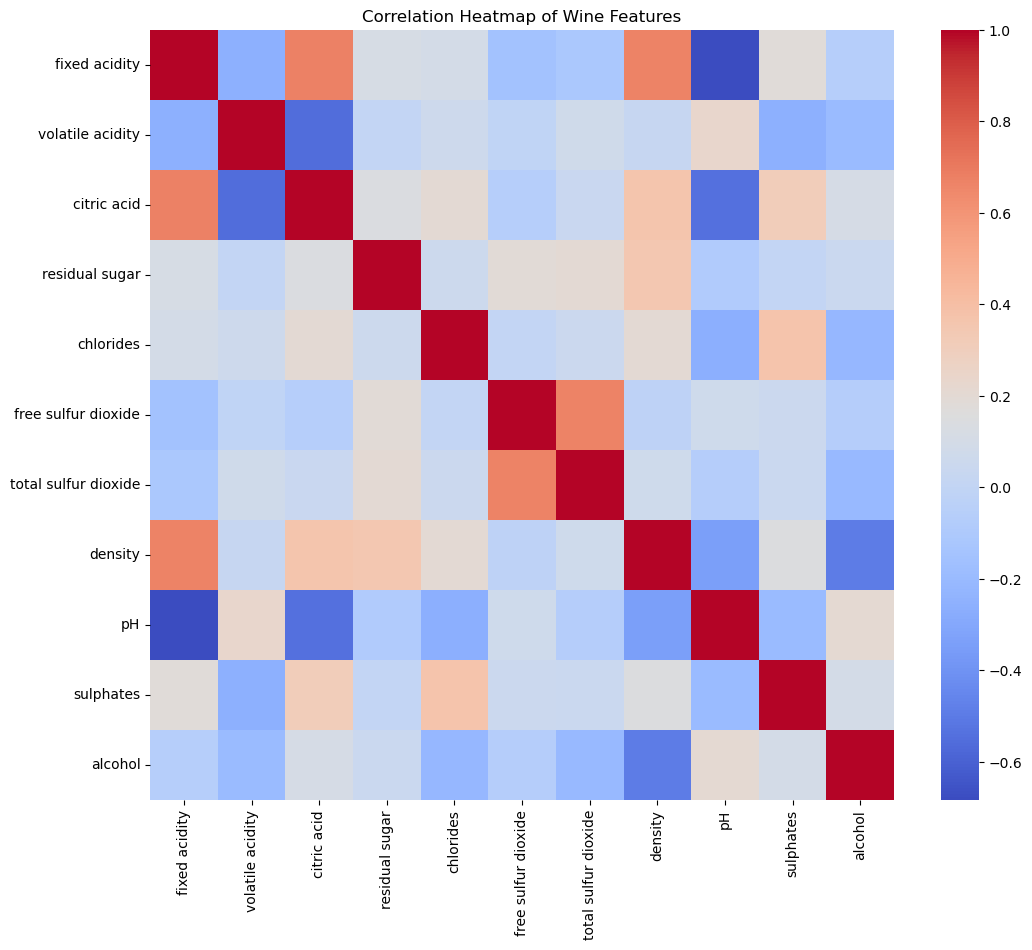

In [52]:
plt.figure(figsize=(12, 10))
sns.heatmap(
    df.drop(columns=["quality", "target"]).corr(),
    cmap="coolwarm",
    annot=False
)
plt.title("Correlation Heatmap of Wine Features")
plt.show()


In [48]:
df["target"] = (df["quality"] >= 6).astype(int)

# Build feature matrix X and label vector y
X = df.drop(columns=["quality", "target"]).values
y = df["target"].values

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (1599, 11)
y shape: (1599,)


## Converting Quality to a Binary Classification Target

To simplify modeling, we classify wines into:

- **Good (1)** if quality ≥ 6  
- **Bad (0)** otherwise

This creates a balanced, interpretable target for a Decision Tree.


In [50]:
from rice2025.utils.train_test_split import train_test_split

X = df.drop(columns=["quality", "target"]).values
y = df["target"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42,
)

X_train.shape, X_test.shape


((1200, 11), (399, 11))

## Training our Custom Decision Tree Classifier

Using the `DecisionTree` implementation from the `rice2025` package, we:

- Train the model with a maximum depth (e.g., 4)  
- Predict on train and test sets  
- Evaluate accuracy  

Decision Trees perform well here because many features (like alcohol, sulphates, acidity) have clear threshold-based relationships with quality.


In [53]:
from rice2025.supervised_learning.decision_tree import DecisionTree

tree = DecisionTree(max_depth=4)
tree.fit(X_train, y_train)

train_acc = tree.score(X_train, y_train)
test_acc = tree.score(X_test, y_test)

print("Train Accuracy:", train_acc)
print("Test Accuracy:", test_acc)


Train Accuracy: 0.7533333333333333
Test Accuracy: 0.7117794486215538


## 2D Decision Boundary Visualization using PCA

The wine dataset has 11 features, so we cannot visualize splits directly.  
We use our custom PCA implementation from `rice2025` to reduce the data to 2 components:

- Train a Decision Tree on the PCA-transformed features  
- Plot the decision boundaries  
- Overlay the test samples  

This provides intuition for how the Decision Tree separates wines.


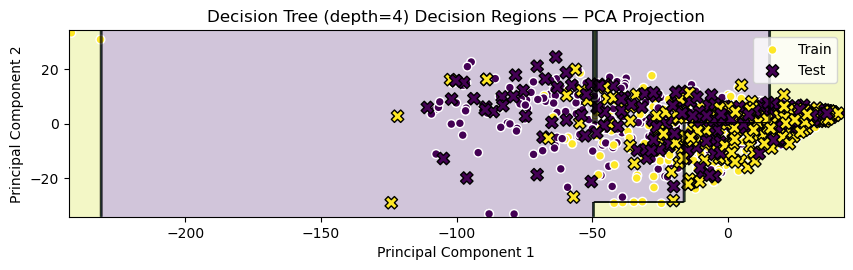

In [57]:
from rice2025.unsupervised_learning.pca import PCA

# PCA reduce to 2D
pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train)
X_test_2d = pca.transform(X_test)

# Train decision tree on 2D data
tree_2d = DecisionTree(max_depth=4)
tree_2d.fit(X_train_2d, y_train)

# Meshgrid for contour
x_min, x_max = X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1
y_min, y_max = X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)

Z = tree_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))
ax = plt.gca()
ax.set_aspect('equal', 'box')   # ⭐ THIS FIXES THE WEIRD SHAPING

# Decision regions
plt.contourf(xx, yy, Z, alpha=0.25, cmap="viridis")
plt.contour(xx, yy, Z, colors="black", linewidths=0.3)

# Train points
plt.scatter(
    X_train_2d[:, 0], X_train_2d[:, 1],
    c=y_train, cmap="viridis",
    edgecolor="white", s=40, label="Train"
)

# Test points
plt.scatter(
    X_test_2d[:, 0], X_test_2d[:, 1],
    c=y_test, cmap="viridis",
    edgecolor="black", s=80, marker="X", label="Test"
)

plt.title("Decision Tree (depth=4) Decision Regions — PCA Projection")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()


# Conclusion

In this notebook, we implemented and evaluated a **custom Decision Tree classifier** from scratch using the `rice2025` package. After converting the multiclass wine quality scores into a binary target, we trained the model and assessed its performance on both the original feature space and a 2D PCA projection for visualization.

The model achieved a **train accuracy of ~0.75** and a **test accuracy of ~0.71**, indicating that the tree is able to learn meaningful structure from the data while avoiding extreme overfitting. The relatively small gap between train and test performance suggests a good balance between model complexity and generalization.

Using PCA to project the 11-dimensional dataset onto two principal components allowed us to visualize how the decision tree partitions the feature space. Because decision trees rely on **axis-aligned splits**, these boundaries appear as vertical or horizontal lines in PCA space. While this makes the model highly interpretable, it also highlights a key limitation: linear PCA combinations may not align with the tree’s natural splitting structure, which can reduce visual smoothness and classification flexibility in the 2D view.

Overall, this experiment illustrates:

- How a decision tree learns hierarchical rules based on feature thresholds  
- How restricting tree depth controls model complexity  
- How PCA can help visualize high-dimensional decision boundaries  
- The practical trade-offs between interpretability and predictive flexibility  

This completes our supervised learning example for decision trees using our custom implementation. The workflow here serves as a template for how to analyze additional models within the `rice2025` package.
